#Image classification of Cifar 10 dataset using Resnet 18 CNN model , albumentation image augmentation and gradcam image

### Submitted by Deepak Hazarika  , Parinita Bora , Gurudatta

In [1]:
!python --version

Python 3.6.9


In [2]:
!pip install PyDrive

## Import pydrive modules

In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


In [4]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


## Upload the cifar 10 image files from google drive to colab

Instead of downloading the cifar 10 dataset from web , a copy is saved in google drive.

In [5]:

downloaded = drive.CreateFile({'id':"1fohphdiuj_-zG7EwFnRzj4NQ3rZRu_PY"})   # replace the id with id of file you want to access
downloaded.GetContentFile('cifar10.zip')

In [6]:
from zipfile import ZipFile

## Extract the images into a local folder

In [7]:
with ZipFile('/content/cifar10.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

### Initialize the parameters

In [9]:
EPOCHS = 50
BATCH_SIZE = 128
WEIGHT_DECAY = 1e-2
TRAIN_DATASET_SIZE = 50000
BUCKET_SIZE = 5
NUMBER_OF_BATCHES =  TRAIN_DATASET_SIZE // BATCH_SIZE
NUMBER_OF_BUCKETS = NUMBER_OF_BATCHES // BUCKET_SIZE
DATAFOLDER = "/content/cifar10/"
NUM_LR_FINDER_ITER = 500
END_LR = 1

## Import the model library from https://github.com/tfdeepnet/visionlib.git

In [10]:
!git clone https://github.com/tfdeepnet/visionlib.git

Cloning into 'visionlib'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 373 (delta 3), reused 8 (delta 3), pack-reused 365
Receiving objects: 100% (373/373), 112.73 KiB | 8.67 MiB/s, done.
Resolving deltas: 100% (225/225), done.


In [11]:
!pip install -e /content/visionlib 


Obtaining file:///content/visionlib
  Running setup.py develop for visionlib


In [12]:
import visionlib.models as vl
import visionlib.utils as utl
#import visionlib.albumentations as A


In [13]:
%matplotlib inline

## Import the libraries

In [14]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import cv2
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau

## Prepare a list of albumentation for train and test data 





In [15]:
import albumentations as A

channel_means = (0.5, 0.5, 0.5)
channel_stdevs = (0.5, 0.5, 0.5)
train_transform_list = [#A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=20, val_shift_limit=10, p=0.3),
                        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.9, rotate_limit=10, p=0.3),
                        A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
                        A.HorizontalFlip(),
                        A.Normalize(mean=channel_means, std=channel_stdevs),
                        A.Cutout(num_holes=1, max_h_size=16,max_w_size = 16,p=1)]
# Test Phase transformations
test_transform_list = [A.Normalize(mean=channel_means, std=channel_stdevs)]

##  Use the loaddata utility from visionlib library to load train and test data

In [16]:
trainloader, testloader = utl.loadalbumentationdata(DATAFOLDER , BATCH_SIZE , train_transform_list, test_transform_list )


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Let us show some of the training images, for fun.



img shape  torch.Size([128, 3, 32, 32])


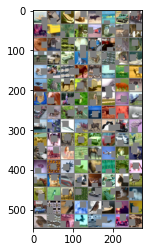

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

print("img shape " , images.shape)


# show images
imshow(torchvision.utils.make_grid(images))
# print labels
#print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Instantiate a resnet18 model to train and test the cifar 10 dataset


In [18]:
net = vl.ResNet18()

### Get the model summary alongwith the recepive field at each layer

In [19]:
#!pip install torchsummary
#from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

utl.summary(net.to(device), input_size=(3, 32, 32))

cuda
-----------------------------------------------------------------------------------------------
        Layer (type) |              Output Shape |         Param # |          RF out |         Jump in
            Conv2d-1 |          [-1, 64, 32, 32] |           1,728 |               3 |               1
       BatchNorm2d-2 |          [-1, 64, 32, 32] |             128 |               0 |               0
            Conv2d-3 |          [-1, 64, 32, 32] |          36,864 |               5 |               1
       BatchNorm2d-4 |          [-1, 64, 32, 32] |             128 |               0 |               0
            Conv2d-5 |          [-1, 64, 32, 32] |          36,864 |               7 |               1
       BatchNorm2d-6 |          [-1, 64, 32, 32] |             128 |               0 |               0
        BasicBlock-7 |          [-1, 64, 32, 32] |               0 |               0 |               0
            Conv2d-8 |          [-1, 64, 32, 32] |          36,864 |       

(tensor(11173962), tensor(11173962))

## Define a Loss function, optimizer and scheduler 

Let's use a Classification Cross-Entropy loss , SGD with momentum and StepLR to vary the learning rate progressively.



In [20]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-5, weight_decay=WEIGHT_DECAY , momentum=0.9)
#scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

## LR finder 

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.10E-02


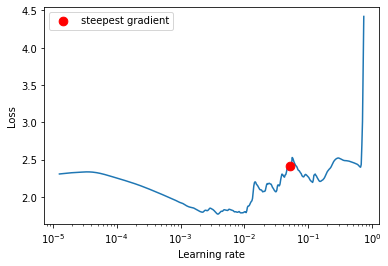

(<matplotlib.axes._subplots.AxesSubplot at 0x7f6e71f2c0b8>,
 0.05098176064420424)

In [21]:
lr_finder = utl.LRFinder(net, optimizer, criterion, device="cuda")
lr_finder.range_test(trainloader, val_loader=testloader, end_lr=END_LR, num_iter=NUM_LR_FINDER_ITER ,step_mode="exp")
lr_finder.plot() # to inspect the loss-learning rate graph
# to reset the model and optimizer to their initial state

In [22]:
optim_lr = lr_finder.history['lr'][lr_finder.history['loss'].index(lr_finder.best_loss)]
optim_lr

0.0038474265772585033

In [23]:
lr_finder.reset() 

## Apply the optimum LR found by LR finder

In [24]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr= optim_lr, momentum=0.9,weight_decay=WEIGHT_DECAY, nesterov=True)
scheduler = ReduceLROnPlateau(optimizer, patience = 2 , min_lr= 0.0001)


## Train the network for 50 epochs



In [25]:
train_loss = [] 
train_acc = []
test_loss = []
test_acc = []

for epoch in range(EPOCHS):  # loop over the dataset multiple times
    print("Epoch:", epoch+1,'LR:',optimizer.param_groups[0]['lr'])
    utl.train(epoch , trainloader, optimizer, net, criterion, NUMBER_OF_BUCKETS , device )
    test_loss,test_acc = utl.test(testloader, net, criterion , device )
    train_loss,train_acc = utl.train_metrics(trainloader, net, criterion , device )
    scheduler.step(test_acc[-1])            

print('Finished Training')

  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 1 LR: 0.0038474265772585033


Loss=1.3753328323364258 Batch_id=390 Accuracy=41.85: 100%|██████████| 391/391 [01:04<00:00,  6.06it/s]



Test set: Average loss: 0.0093, Accuracy: 5858/10000 (58.58%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 2 LR: 0.0038474265772585033


Loss=1.0733284950256348 Batch_id=390 Accuracy=58.39: 100%|██████████| 391/391 [01:04<00:00,  6.06it/s]



Test set: Average loss: 0.0081, Accuracy: 6398/10000 (63.98%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 3 LR: 0.0038474265772585033


Loss=1.0811073780059814 Batch_id=390 Accuracy=64.02: 100%|██████████| 391/391 [01:04<00:00,  6.03it/s]



Test set: Average loss: 0.0073, Accuracy: 6739/10000 (67.39%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 4 LR: 0.0038474265772585033


Loss=0.8335278630256653 Batch_id=390 Accuracy=67.09: 100%|██████████| 391/391 [01:04<00:00,  6.06it/s]



Test set: Average loss: 0.0061, Accuracy: 7358/10000 (73.58%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 5 LR: 0.00038474265772585033


Loss=0.6821111440658569 Batch_id=390 Accuracy=72.58: 100%|██████████| 391/391 [01:04<00:00,  6.05it/s]



Test set: Average loss: 0.0040, Accuracy: 8256/10000 (82.56%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 6 LR: 0.00038474265772585033


Loss=0.7361990809440613 Batch_id=390 Accuracy=74.68: 100%|██████████| 391/391 [01:04<00:00,  6.06it/s]



Test set: Average loss: 0.0038, Accuracy: 8341/10000 (83.41%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 7 LR: 0.00038474265772585033


Loss=0.9723490476608276 Batch_id=390 Accuracy=75.62: 100%|██████████| 391/391 [01:04<00:00,  6.05it/s]



Test set: Average loss: 0.0037, Accuracy: 8379/10000 (83.79%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 8 LR: 0.0001


Loss=0.7198494672775269 Batch_id=390 Accuracy=76.89: 100%|██████████| 391/391 [01:04<00:00,  6.06it/s]



Test set: Average loss: 0.0035, Accuracy: 8465/10000 (84.65%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 9 LR: 0.0001


Loss=0.7850466966629028 Batch_id=390 Accuracy=77.08: 100%|██████████| 391/391 [01:04<00:00,  6.05it/s]



Test set: Average loss: 0.0035, Accuracy: 8502/10000 (85.02%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 10 LR: 0.0001


Loss=0.6626682281494141 Batch_id=390 Accuracy=77.46: 100%|██████████| 391/391 [01:04<00:00,  6.07it/s]



Test set: Average loss: 0.0034, Accuracy: 8527/10000 (85.27%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 11 LR: 0.0001


Loss=0.6013997197151184 Batch_id=390 Accuracy=77.62: 100%|██████████| 391/391 [01:04<00:00,  6.06it/s]



Test set: Average loss: 0.0034, Accuracy: 8531/10000 (85.31%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 12 LR: 0.0001


Loss=0.6730393171310425 Batch_id=390 Accuracy=77.77: 100%|██████████| 391/391 [01:04<00:00,  6.07it/s]



Test set: Average loss: 0.0034, Accuracy: 8550/10000 (85.50%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 13 LR: 0.0001


Loss=0.7388104200363159 Batch_id=390 Accuracy=78.04: 100%|██████████| 391/391 [01:04<00:00,  6.06it/s]



Test set: Average loss: 0.0033, Accuracy: 8547/10000 (85.47%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 14 LR: 0.0001


Loss=0.6825569868087769 Batch_id=390 Accuracy=78.37: 100%|██████████| 391/391 [01:04<00:00,  6.08it/s]



Test set: Average loss: 0.0033, Accuracy: 8554/10000 (85.54%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 15 LR: 0.0001


Loss=0.5870542526245117 Batch_id=390 Accuracy=78.78: 100%|██████████| 391/391 [01:04<00:00,  6.08it/s]



Test set: Average loss: 0.0033, Accuracy: 8578/10000 (85.78%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 16 LR: 0.0001


Loss=0.5619879961013794 Batch_id=390 Accuracy=78.62: 100%|██████████| 391/391 [01:04<00:00,  6.06it/s]



Test set: Average loss: 0.0032, Accuracy: 8595/10000 (85.95%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 17 LR: 0.0001


Loss=0.6910077333450317 Batch_id=390 Accuracy=78.64: 100%|██████████| 391/391 [01:04<00:00,  6.07it/s]



Test set: Average loss: 0.0032, Accuracy: 8607/10000 (86.07%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 18 LR: 0.0001


Loss=0.5318809747695923 Batch_id=390 Accuracy=79.17: 100%|██████████| 391/391 [01:04<00:00,  6.08it/s]



Test set: Average loss: 0.0033, Accuracy: 8621/10000 (86.21%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 19 LR: 0.0001


Loss=0.6488356590270996 Batch_id=390 Accuracy=79.04: 100%|██████████| 391/391 [01:04<00:00,  6.08it/s]



Test set: Average loss: 0.0031, Accuracy: 8627/10000 (86.27%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 20 LR: 0.0001


Loss=0.6983246207237244 Batch_id=390 Accuracy=78.94: 100%|██████████| 391/391 [01:04<00:00,  6.08it/s]



Test set: Average loss: 0.0032, Accuracy: 8638/10000 (86.38%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 21 LR: 0.0001


Loss=0.6072720289230347 Batch_id=390 Accuracy=79.57: 100%|██████████| 391/391 [01:04<00:00,  6.08it/s]



Test set: Average loss: 0.0031, Accuracy: 8662/10000 (86.62%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 22 LR: 0.0001


Loss=0.5095802545547485 Batch_id=390 Accuracy=79.88: 100%|██████████| 391/391 [01:04<00:00,  6.08it/s]



Test set: Average loss: 0.0031, Accuracy: 8671/10000 (86.71%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 23 LR: 0.0001


Loss=0.5787743926048279 Batch_id=390 Accuracy=80.07: 100%|██████████| 391/391 [01:04<00:00,  6.09it/s]



Test set: Average loss: 0.0031, Accuracy: 8647/10000 (86.47%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 24 LR: 0.0001


Loss=0.46584028005599976 Batch_id=390 Accuracy=80.43: 100%|██████████| 391/391 [01:04<00:00,  6.07it/s]



Test set: Average loss: 0.0030, Accuracy: 8679/10000 (86.79%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 25 LR: 0.0001


Loss=0.5583087205886841 Batch_id=390 Accuracy=80.43: 100%|██████████| 391/391 [01:04<00:00,  6.05it/s]



Test set: Average loss: 0.0031, Accuracy: 8668/10000 (86.68%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 26 LR: 0.0001


Loss=0.6336607933044434 Batch_id=390 Accuracy=80.41: 100%|██████████| 391/391 [01:04<00:00,  6.06it/s]



Test set: Average loss: 0.0030, Accuracy: 8687/10000 (86.87%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 27 LR: 0.0001


Loss=0.6018742918968201 Batch_id=390 Accuracy=80.94: 100%|██████████| 391/391 [01:04<00:00,  6.06it/s]



Test set: Average loss: 0.0030, Accuracy: 8703/10000 (87.03%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 28 LR: 0.0001


Loss=0.4188395142555237 Batch_id=390 Accuracy=81.03: 100%|██████████| 391/391 [01:04<00:00,  6.08it/s]



Test set: Average loss: 0.0030, Accuracy: 8710/10000 (87.10%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 29 LR: 0.0001


Loss=0.5444439649581909 Batch_id=390 Accuracy=81.01: 100%|██████████| 391/391 [01:04<00:00,  6.06it/s]



Test set: Average loss: 0.0029, Accuracy: 8723/10000 (87.23%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 30 LR: 0.0001


Loss=0.6400378942489624 Batch_id=390 Accuracy=81.29: 100%|██████████| 391/391 [01:04<00:00,  6.05it/s]



Test set: Average loss: 0.0030, Accuracy: 8712/10000 (87.12%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 31 LR: 0.0001


Loss=0.5289729833602905 Batch_id=390 Accuracy=81.29: 100%|██████████| 391/391 [01:04<00:00,  6.07it/s]



Test set: Average loss: 0.0029, Accuracy: 8748/10000 (87.48%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 32 LR: 0.0001


Loss=0.6471609473228455 Batch_id=390 Accuracy=81.60: 100%|██████████| 391/391 [01:04<00:00,  6.07it/s]



Test set: Average loss: 0.0029, Accuracy: 8743/10000 (87.43%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 33 LR: 0.0001


Loss=0.5634828209877014 Batch_id=390 Accuracy=81.91: 100%|██████████| 391/391 [01:04<00:00,  6.06it/s]



Test set: Average loss: 0.0029, Accuracy: 8763/10000 (87.63%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 34 LR: 0.0001


Loss=0.49017539620399475 Batch_id=390 Accuracy=82.02: 100%|██████████| 391/391 [01:04<00:00,  6.04it/s]



Test set: Average loss: 0.0029, Accuracy: 8753/10000 (87.53%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 35 LR: 0.0001


Loss=0.4794551432132721 Batch_id=390 Accuracy=82.26: 100%|██████████| 391/391 [01:04<00:00,  6.05it/s]



Test set: Average loss: 0.0029, Accuracy: 8746/10000 (87.46%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 36 LR: 0.0001


Loss=0.49800652265548706 Batch_id=390 Accuracy=81.98: 100%|██████████| 391/391 [01:04<00:00,  6.05it/s]



Test set: Average loss: 0.0029, Accuracy: 8760/10000 (87.60%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 37 LR: 0.0001


Loss=0.45988911390304565 Batch_id=390 Accuracy=82.44: 100%|██████████| 391/391 [01:04<00:00,  6.06it/s]



Test set: Average loss: 0.0029, Accuracy: 8732/10000 (87.32%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 38 LR: 0.0001


Loss=0.606822669506073 Batch_id=390 Accuracy=82.76: 100%|██████████| 391/391 [01:04<00:00,  6.07it/s]



Test set: Average loss: 0.0028, Accuracy: 8803/10000 (88.03%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 39 LR: 0.0001


Loss=0.7421718835830688 Batch_id=390 Accuracy=82.82: 100%|██████████| 391/391 [01:04<00:00,  6.04it/s]



Test set: Average loss: 0.0028, Accuracy: 8796/10000 (87.96%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 40 LR: 0.0001


Loss=0.48071855306625366 Batch_id=390 Accuracy=82.75: 100%|██████████| 391/391 [01:04<00:00,  6.06it/s]



Test set: Average loss: 0.0028, Accuracy: 8811/10000 (88.11%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 41 LR: 0.0001


Loss=0.5312708616256714 Batch_id=390 Accuracy=83.00: 100%|██████████| 391/391 [01:04<00:00,  6.05it/s]



Test set: Average loss: 0.0028, Accuracy: 8788/10000 (87.88%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 42 LR: 0.0001


Loss=0.5292736887931824 Batch_id=390 Accuracy=83.11: 100%|██████████| 391/391 [01:04<00:00,  6.08it/s]



Test set: Average loss: 0.0028, Accuracy: 8820/10000 (88.20%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 43 LR: 0.0001


Loss=0.5096736550331116 Batch_id=390 Accuracy=83.59: 100%|██████████| 391/391 [01:04<00:00,  6.05it/s]



Test set: Average loss: 0.0029, Accuracy: 8744/10000 (87.44%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 44 LR: 0.0001


Loss=0.5373687744140625 Batch_id=390 Accuracy=83.78: 100%|██████████| 391/391 [01:04<00:00,  6.05it/s]



Test set: Average loss: 0.0027, Accuracy: 8866/10000 (88.66%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 45 LR: 0.0001


Loss=0.40940237045288086 Batch_id=390 Accuracy=83.56: 100%|██████████| 391/391 [01:04<00:00,  6.07it/s]



Test set: Average loss: 0.0027, Accuracy: 8847/10000 (88.47%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 46 LR: 0.0001


Loss=0.51006019115448 Batch_id=390 Accuracy=83.84: 100%|██████████| 391/391 [01:04<00:00,  6.05it/s]



Test set: Average loss: 0.0028, Accuracy: 8796/10000 (87.96%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 47 LR: 0.0001


Loss=0.43844109773635864 Batch_id=390 Accuracy=83.89: 100%|██████████| 391/391 [01:04<00:00,  6.05it/s]



Test set: Average loss: 0.0027, Accuracy: 8814/10000 (88.14%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 48 LR: 0.0001


Loss=0.3344542384147644 Batch_id=390 Accuracy=84.26: 100%|██████████| 391/391 [01:04<00:00,  6.07it/s]



Test set: Average loss: 0.0027, Accuracy: 8868/10000 (88.68%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 49 LR: 0.0001


Loss=0.4570693075656891 Batch_id=390 Accuracy=84.13: 100%|██████████| 391/391 [01:04<00:00,  6.03it/s]



Test set: Average loss: 0.0028, Accuracy: 8817/10000 (88.17%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 50 LR: 0.0001


Loss=0.41075414419174194 Batch_id=390 Accuracy=84.34: 100%|██████████| 391/391 [01:04<00:00,  6.07it/s]



Test set: Average loss: 0.0027, Accuracy: 8860/10000 (88.60%)

Finished Training


### Let us display a batch of image from the test set to get familiar.



GroundTruth:    car truck  deer  bird  bird  bird  frog   dog   dog  frog truck truck truck plane plane   cat  deer   cat   dog   cat  frog horse plane truck   car plane  bird   cat  bird  bird   car   dog  bird  deer horse horse   car horse horse truck  deer truck   car truck  frog  ship   cat truck  frog  bird  deer  deer  bird truck   dog truck truck   cat plane   cat   car plane   cat   car   car  deer  ship truck   car  ship  frog   cat   cat  bird   car  frog  deer truck   cat truck truck horse  deer  deer truck plane horse horse plane plane   cat truck  bird  frog   cat truck   car  deer   cat truck horse   car   cat   car  deer  deer  deer  bird  ship   cat  bird  ship   dog   car  ship  frog  frog plane plane   cat   car  frog  bird  deer   dog   car  frog  ship


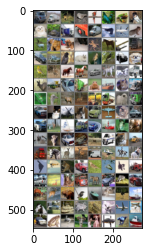

In [26]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(BATCH_SIZE)))

## Test accuracy at each class level

In [30]:
   
misclassifiedimages = utl.get_validation_result_and_misclassifiedimages(net , device , classes , testloader ) 

Class accuracy 

Accuracy of plane : 90 % 

Accuracy of   car : 95 % 

Accuracy of  bird : 83 % 

Accuracy of   cat : 74 % 

Accuracy of  deer : 89 % 

Accuracy of   dog : 75 % 

Accuracy of  frog : 94 % 

Accuracy of horse : 91 % 

Accuracy of  ship : 95 % 

Accuracy of truck : 94 % 


 Accuracy of the network on the 10000 test images: 88.60 %


## Test accuracy 88.6% (randomly picking a class out of 10 classes).
Seems like the network learnt something.

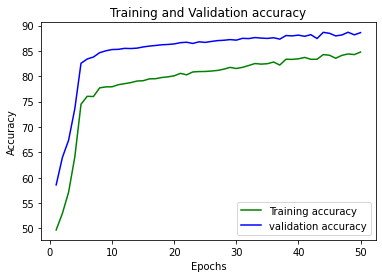

In [31]:
utl.plot_train_vs_test_accuracy(EPOCHS , train_acc , test_acc)

## Visualize misclassified test images

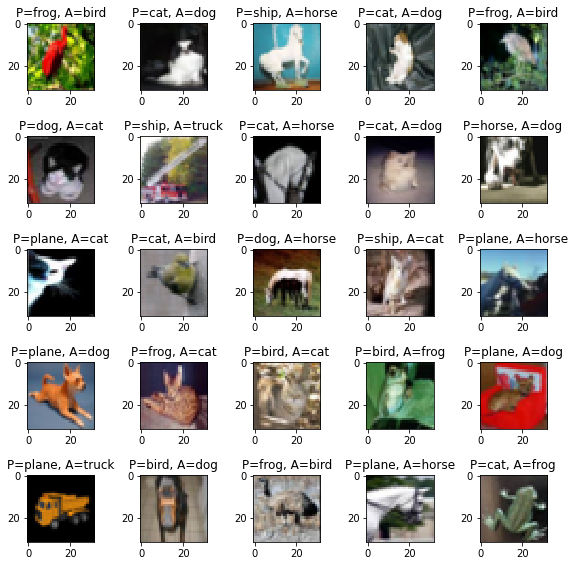

In [32]:
utl.view_misclassified_images(misclassifiedimages , classes)

In [33]:

import numpy as np
import matplotlib.pyplot as plt

def imshowgradcam(img,c = "" ):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    fig = plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)),interpolation='none')
    plt.title(c)

## GradCam of misclassified images

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or 

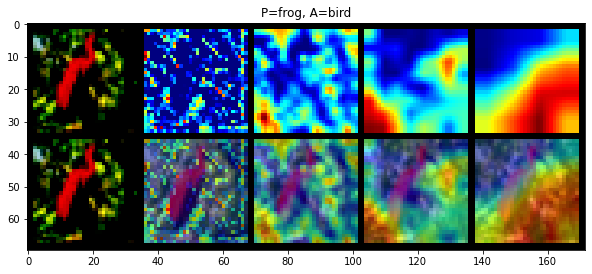

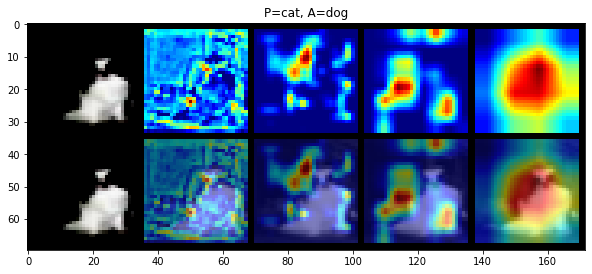

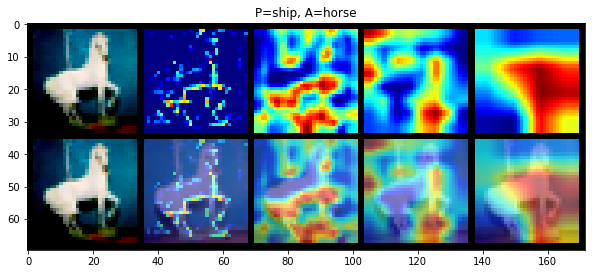

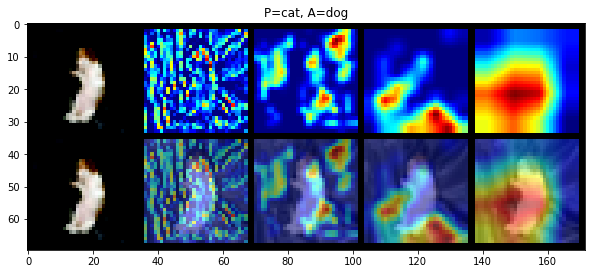

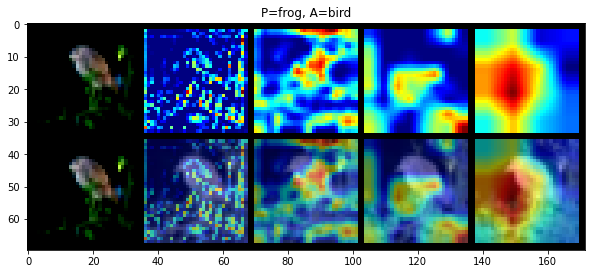

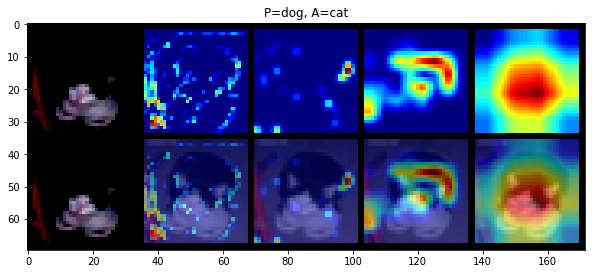

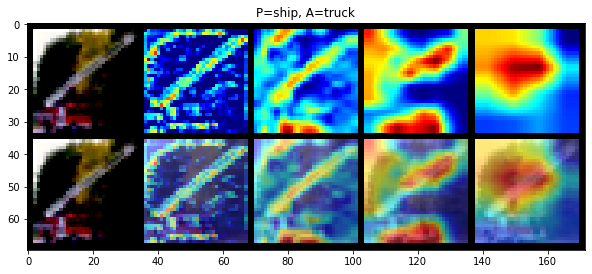

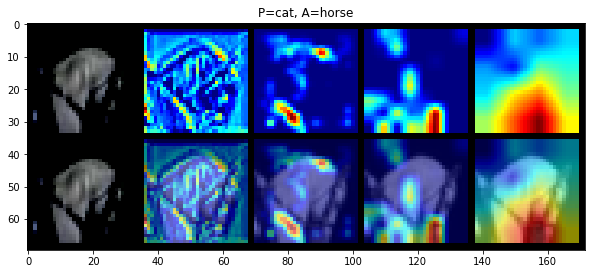

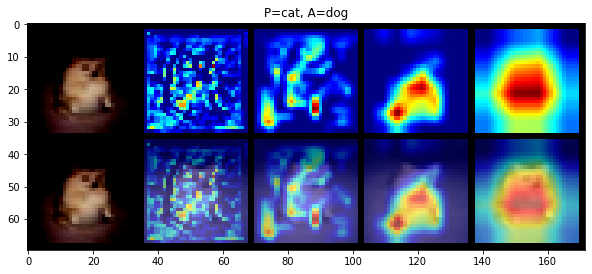

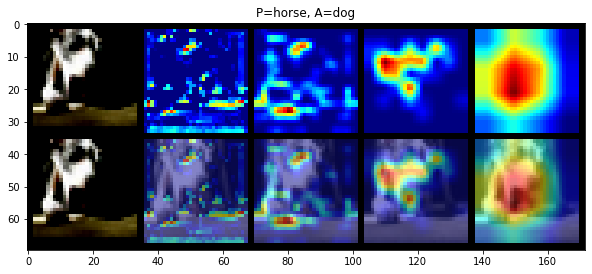

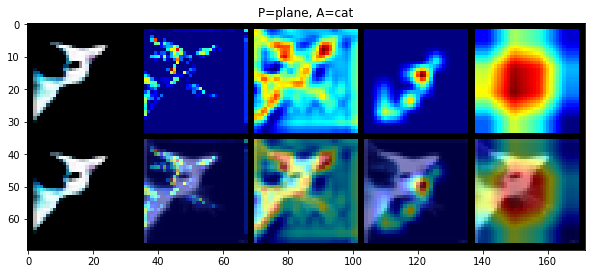

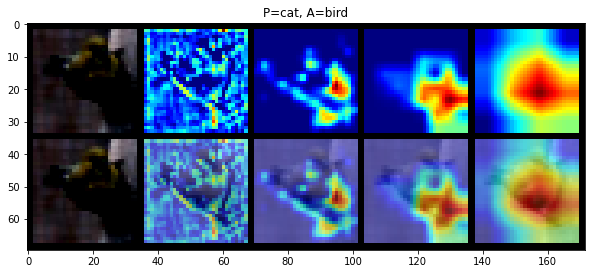

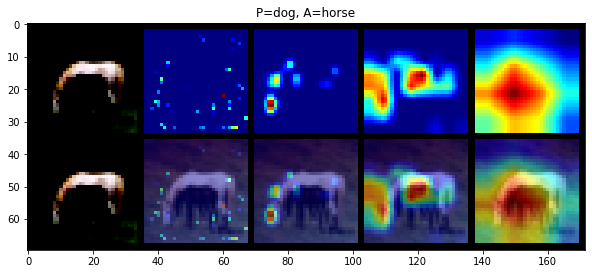

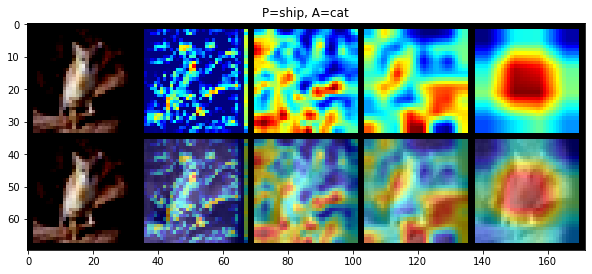

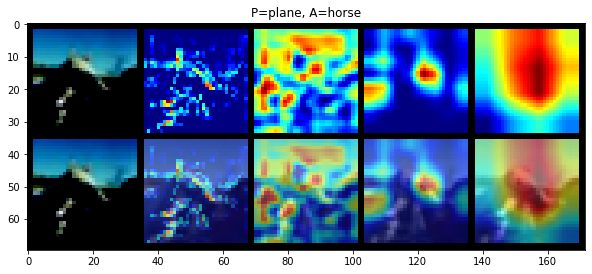

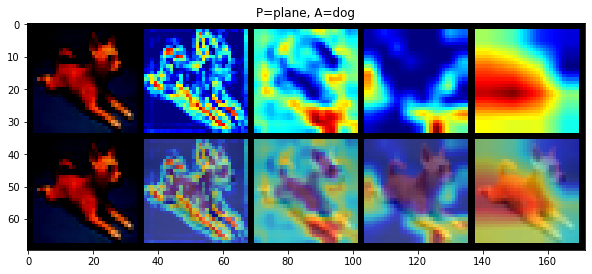

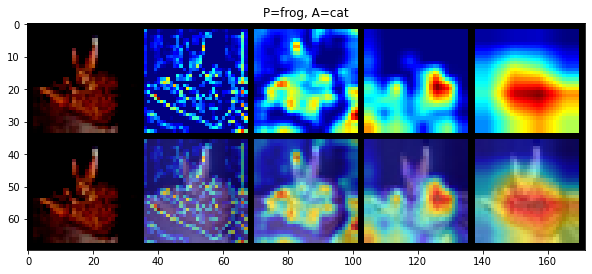

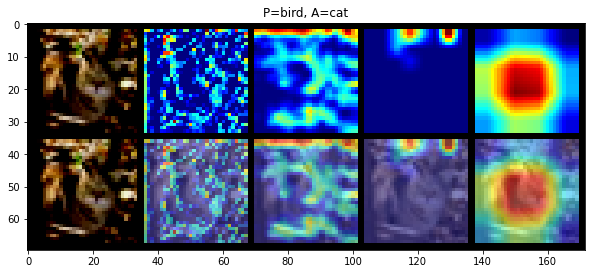

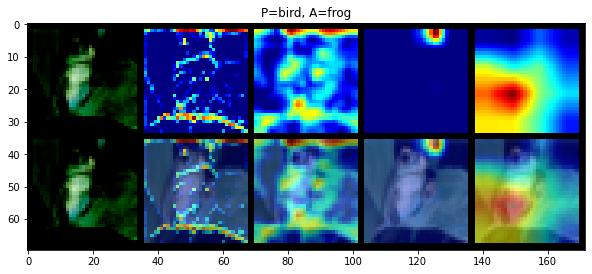

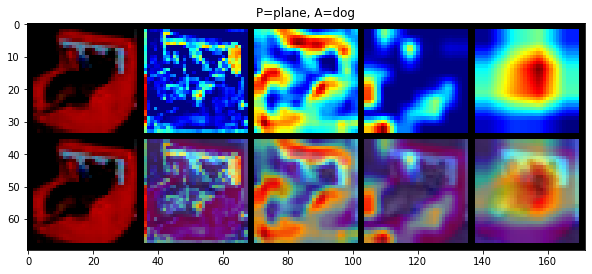

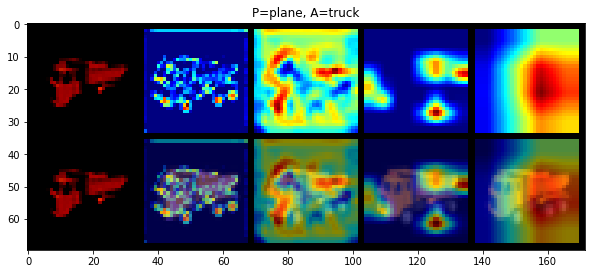

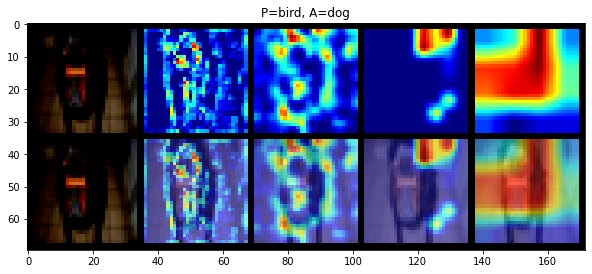

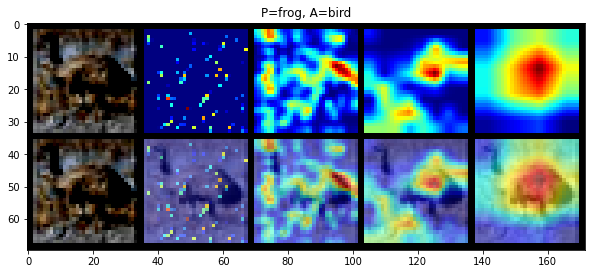

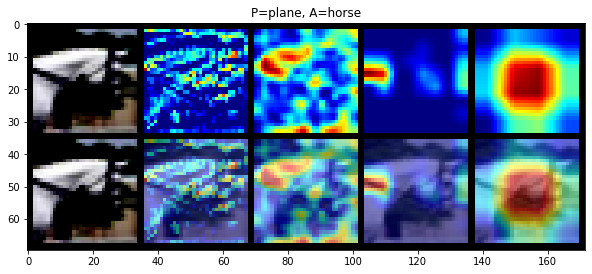

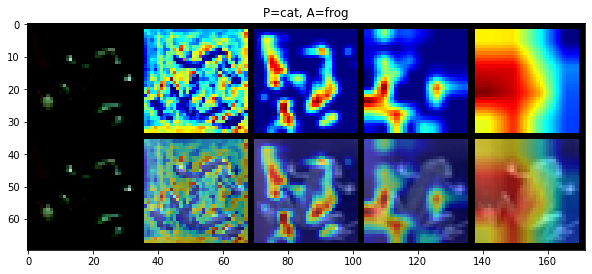

In [34]:
import copy
from torchvision.utils import make_grid, save_image
for i,k in enumerate(misclassifiedimages):
  images1 = [misclassifiedimages[i][0].cpu()]
  images2 =  [misclassifiedimages[i][0].cpu()]
  b = copy.deepcopy(net.to(device))
  output = net(misclassifiedimages[i][0].unsqueeze(0))
  _, predicted = torch.max(output.data, 1)
  layers =  [b.layer1,b.layer2,b.layer3,b.layer4]
  for j in layers:
    g = utl.GradCAM(b,j)
    # mask, _= g(gradcam_misclassified_images[i][0].unsqueeze(0))
    # heatmap, result = visualize_cam(mask,gradcam_misclassified_images[i][0])
    mask, _= g(misclassifiedimages[i][0].clone().unsqueeze_(0))
    heatmap, result = utl.visualize_cam(mask,misclassifiedimages[i][0].clone().unsqueeze_(0)/2+0.5 )
    images1.extend([heatmap])
    images2.extend([result])
  grid_image = make_grid(images1+images2,nrow=5)
  # imshow(grid_image,c = classes[int(predicted)])
  imshowgradcam(grid_image,c = "P={}, A={}".format(str(classes[misclassifiedimages[i][1].data.cpu().numpy()]),str(classes[misclassifiedimages[i][2].data.cpu().numpy()])))